# Install Dependencies and Fetch Dataset

In [1]:
random_state = 1
from pprint import pprint

In [2]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
concrete_compressive_strength = fetch_ucirepo(id=165)

# data (as pandas dataframes)
X = concrete_compressive_strength.data.features
y = concrete_compressive_strength.data.targets

# metadata
pprint(concrete_compressive_strength.metadata)

# variable information
pprint(concrete_compressive_strength.variables)

{'abstract': 'Concrete is the most important material in civil engineering. '
             'The concrete compressive strength is a highly nonlinear function '
             'of age and ingredients. ',
 'additional_info': {'citation': None,
                     'funded_by': None,
                     'instances_represent': None,
                     'preprocessing_description': None,
                     'purpose': None,
                     'recommended_data_splits': None,
                     'sensitive_data': None,
                     'summary': 'Number of instances \t1030\r\n'
                                'Number of Attributes\t9\r\n'
                                'Attribute breakdown\t8 quantitative input '
                                'variables, and 1 quantitative output '
                                'variable\r\n'
                                'Missing Attribute Values\tNone \r\n',
                     'variable_info': 'Given are the variable name, variable '
     

## Data Preparation

In [3]:
# test and train split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_state
)

# Exploratory Data Analysis (EDA)

## Data Inspection

In [4]:
import pandas as pd

# Display the first few rows of the features and target
display(X_train.head())
display(y_train.head())
display(X_test.head())
display(y_test.head())

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age
612,277.0,0.0,0.0,191.0,0.0,968.0,856.0,28
525,359.0,19.0,141.0,154.0,10.9,942.0,801.0,3
597,272.8,181.9,0.0,185.7,0.0,1012.4,714.3,28
846,366.0,187.0,0.0,191.0,7.0,824.0,757.0,28
259,212.6,0.0,100.4,159.4,10.4,1003.8,903.8,3


,Concrete compressive strength
612,25.97
525,25.12
597,31.38
846,65.91
259,13.33


,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age
339,297.2,0.0,117.5,174.8,9.5,1022.8,753.5,3
244,238.1,0.0,94.1,186.7,7.0,949.9,847.0,3
882,140.0,133.0,103.0,200.0,7.0,916.0,753.0,28
567,203.5,135.7,0.0,185.7,0.0,1076.2,759.3,7
923,162.0,207.0,172.0,216.0,10.0,822.0,638.0,28


,Concrete compressive strength
339,21.91
244,19.93
882,36.44
567,11.96
923,39.84


In [5]:
# Display the shape of the features and target
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (824, 8)
Shape of y_train: (824, 1)
Shape of X_test: (206, 8)
Shape of y_test: (206, 1)


In [6]:
# Display the data types of the features and target
print("Data types of features (X):")
print(X_train.dtypes)
print("\nData types of target (y):")
print(y_train.dtypes)

Data types of features (X):
Cement                float64
Blast Furnace Slag    float64
Fly Ash               float64
Water                 float64
Superplasticizer      float64
Coarse Aggregate      float64
Fine Aggregate        float64
Age                     int64
dtype: object

Data types of target (y):
Concrete compressive strength    float64
dtype: object


## Check for Missing Values

In [7]:
missing_values_X = X.isnull().sum()
missing_values_y = y.isnull().sum()
print("Missing values in features (X):")
print(missing_values_X)
print("\nMissing values in target (y):")
print(missing_values_y)

Missing values in features (X):
Cement                0
Blast Furnace Slag    0
Fly Ash               0
Water                 0
Superplasticizer      0
Coarse Aggregate      0
Fine Aggregate        0
Age                   0
dtype: int64

Missing values in target (y):
Concrete compressive strength    0
dtype: int64


## Summary Statistics

In [8]:
summary_X_train = X_train.describe()
print("Summary statistics for features (X_train):")
print(summary_X_train)

Summary statistics for features (X_train):
           Cement  Blast Furnace Slag     Fly Ash       Water  \
count  824.000000          824.000000  824.000000  824.000000   
mean   279.569053           71.445631   54.552670  181.516869   
std    104.483317           85.417432   64.271947   20.955400   
min    102.000000            0.000000    0.000000  121.800000   
25%    191.675000            0.000000    0.000000  164.900000   
50%    266.000000           19.500000    0.000000  185.000000   
75%    350.000000          142.500000  118.300000  192.000000   
max    540.000000          359.400000  200.100000  247.000000   

       Superplasticizer  Coarse Aggregate  Fine Aggregate         Age  
count        824.000000        824.000000      824.000000  824.000000  
mean           6.012257        973.564199      776.894782   44.609223  
std            5.792116         77.349064       78.344553   60.584698  
min            0.000000        801.000000      594.000000    1.000000  
25%        

In [9]:
summary_y_train = y_train.describe()
print("\nSummary statistics for target (y_train):")
print(summary_y_train)


Summary statistics for target (y_train):
       Concrete compressive strength
count                     824.000000
mean                       35.407828
std                        16.817911
min                         2.330000
25%                        23.047500
50%                        33.745000
75%                        45.370000
max                        81.750000


## Visualizations

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

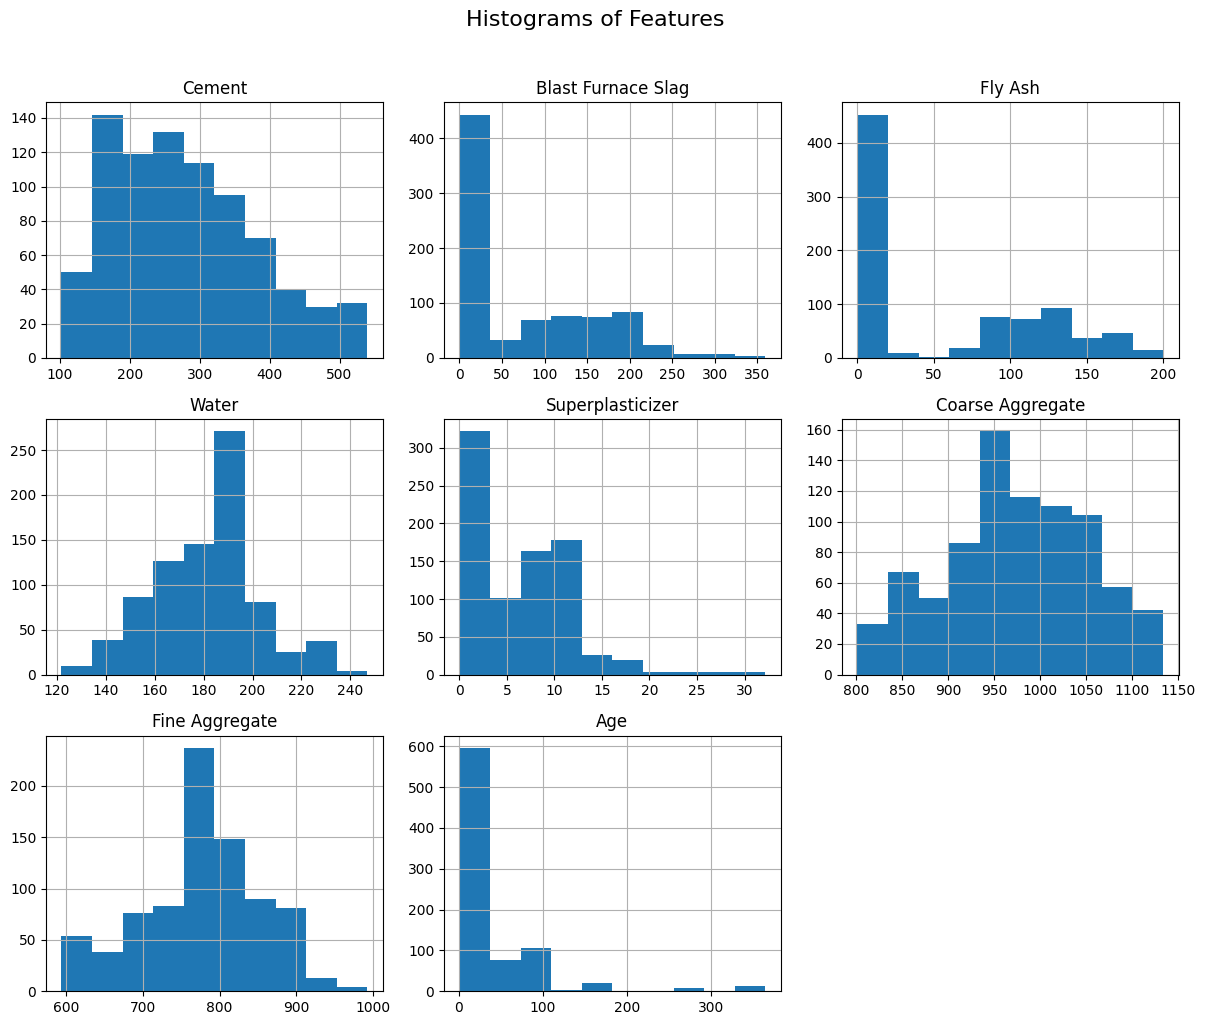

In [11]:
# Histograms for each feature
X_train.hist(figsize=(12, 10))
plt.suptitle("Histograms of Features", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

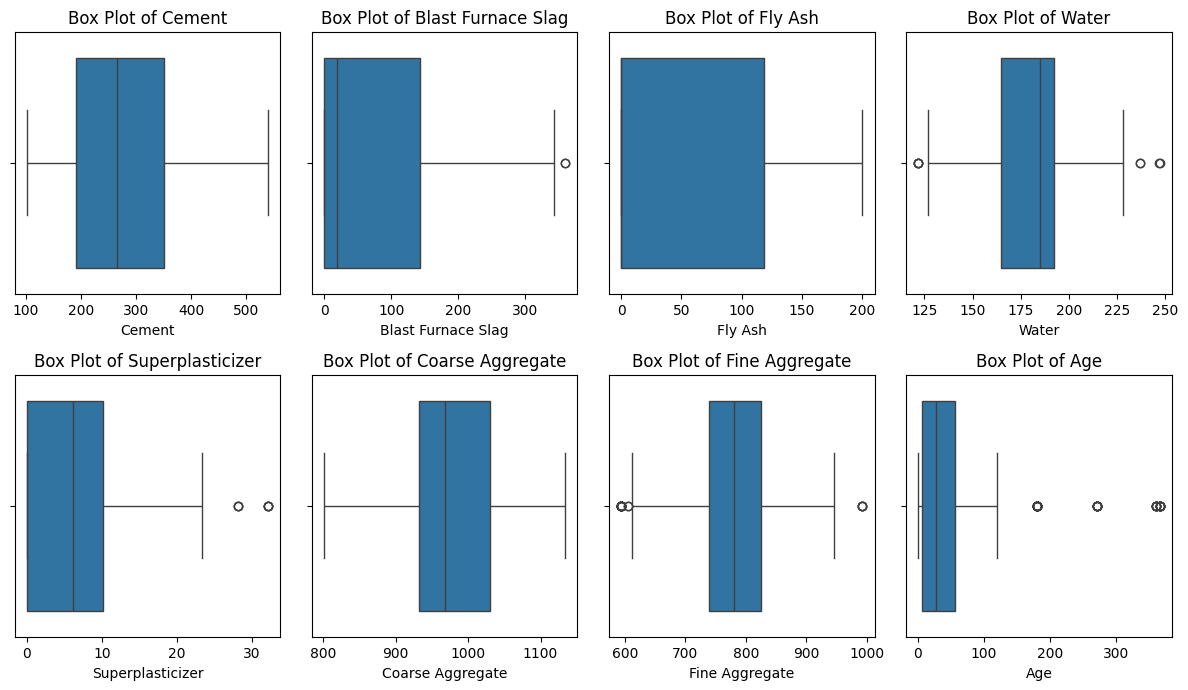

In [12]:
# Box plots for each feature
plt.figure(figsize=(12, 10))
for i, column in enumerate(X_train.columns, 1):
    plt.subplot(3, 4, i)
    sns.boxplot(x=X_train[column])
    plt.title(f"Box Plot of {column}")
plt.tight_layout()
plt.show()

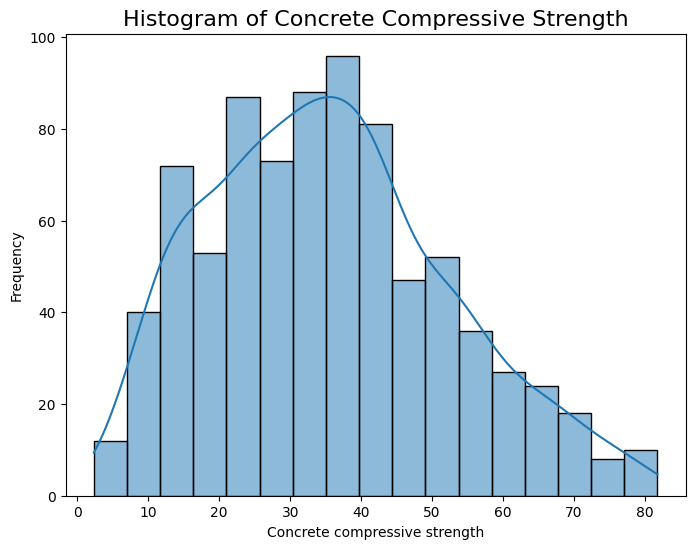

In [13]:
# Histogram of Concrete Compressive Strength
plt.figure(figsize=(8, 6))
sns.histplot(y_train["Concrete compressive strength"], kde=True)
plt.title("Histogram of Concrete Compressive Strength", fontsize=16)
plt.xlabel("Concrete compressive strength")
plt.ylabel("Frequency")
plt.show()

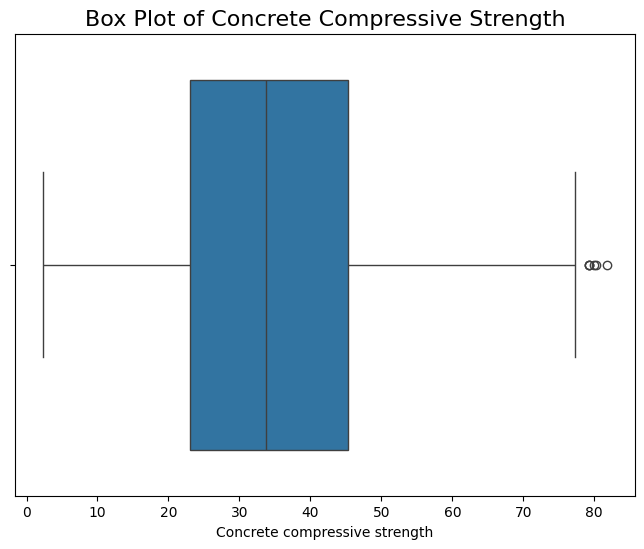

In [14]:
# Box Plot of Concrete Compressive Strength
plt.figure(figsize=(8, 6))
sns.boxplot(x=y_train["Concrete compressive strength"])
plt.title("Box Plot of Concrete Compressive Strength", fontsize=16)
plt.xlabel("Concrete compressive strength")
plt.show()

## Correlation Analysis

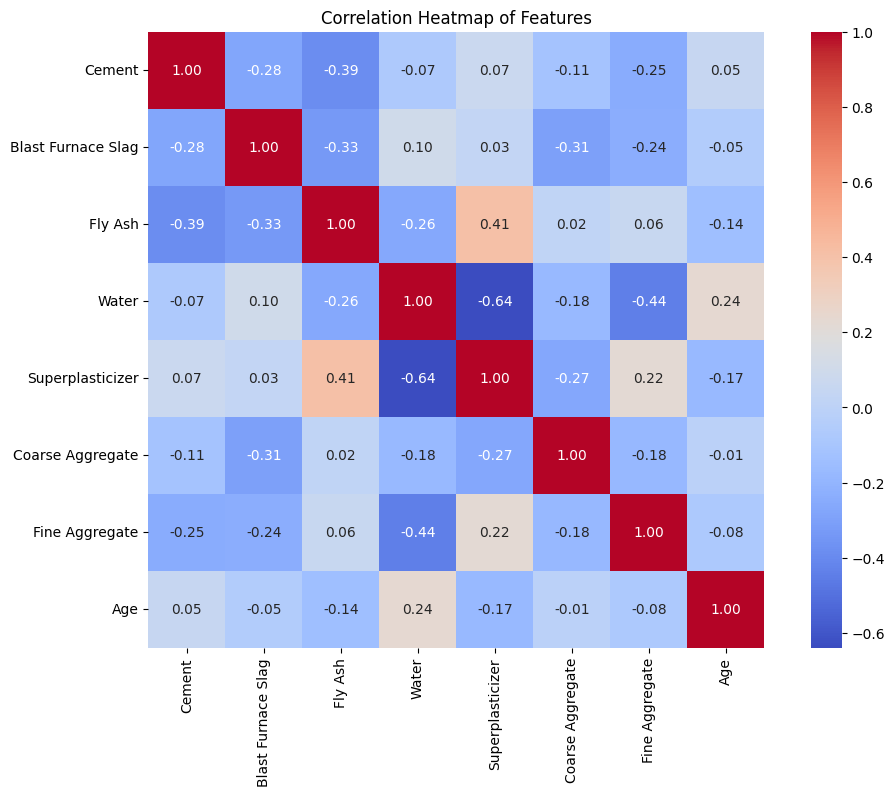

In [15]:
plt.figure(figsize=(12, 8))
correlation_matrix = X_train.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap of Features")
plt.show()

# Bayesian Optimization

## Objective Function

The goal is to optimize the concrete compressive strength using Bayesian optimization. The objective function will be defined to minimize the negative of the compressive strength, as we want to maximize it. The parameters to be optimized will include the features of the concrete mix.

In [16]:
from skopt import BayesSearchCV
from sklearn.ensemble import RandomForestRegressor

In [17]:
# Define the model
model = RandomForestRegressor(random_state=random_state)

In [18]:
# Define the search space for hyperparameters
search_space = {
    "n_estimators": (50, 500),  # Number of trees in the forest
    "max_depth": (5, 50),  # Maximum depth of the tree
    "min_samples_split": (
        2,
        20,
    ),  # Minimum number of samples required to split an internal node
    "min_samples_leaf": (
        1,
        20,
    ),  # Minimum number of samples required to be at a leaf node
    "max_features": [
        "sqrt",
        "log2",
        None,
    ],  # Number of features to consider when looking for the best split
    "bootstrap": [
        True,
        False,
    ],  # Whether bootstrap samples are used when building trees
}

In [19]:
# Define the Bayesian optimization search
opt = BayesSearchCV(
    model,
    search_space,
    n_iter=50,  # Number of iterations for optimization
    scoring="neg_mean_squared_error",  # Objective function to minimize
    cv=5,  # Cross-validation splitting strategy
    n_jobs=-1,  # Use all available cores
    random_state=random_state,
)

In [20]:
# Fit the model using Bayesian optimization
opt.fit(X_train, y_train.values.ravel())

/workspaces/BayesianOptimizationPractice/.venv/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.False_, np.int64(50), np.str_('log2'), np.int64(1), np.int64(2), np.int64(500)] before, using random point [True, np.int64(36), 'sqrt', np.int64(12), np.int64(5), np.int64(170)]
  warnings.warn(
/workspaces/BayesianOptimizationPractice/.venv/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.False_, np.int64(50), np.str_('log2'), np.int64(1), np.int64(2), np.int64(500)] before, using random point [True, np.int64(6), None, np.int64(8), np.int64(20), np.int64(184)]
  warnings.warn(
/workspaces/BayesianOptimizationPractice/.venv/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.False_, np.int64(50), np.str_('log2'), np.int64(1), np.int64(2), np.int64(500)] before, using random point

,estimator,RandomForestR...andom_state=1)
,search_spaces,"{'bootstrap': [True, False], 'max_depth': (5, ...), 'max_features': ['sqrt', 'log2', ...], 'min_samples_leaf': (1, ...), ...}"
,optimizer_kwargs,None
,n_iter,50
,scoring,'neg_mean_squared_error'
,fit_params,None
,n_jobs,-1
,n_points,1
,iid,'deprecated'
,refit,True
,cv,5


In [21]:
# Display the best parameters found by Bayesian optimization
print("Best parameters found by Bayesian optimization:")
pprint(opt.best_params_)

Best parameters found by Bayesian optimization:
OrderedDict([('bootstrap', False),
             ('max_depth', 50),
             ('max_features', 'log2'),
             ('min_samples_leaf', 1),
             ('min_samples_split', 2),
             ('n_estimators', 204)])


In [22]:
# Display the best score achieved
print(f"Best score achieved (negative MSE): {opt.best_score_}")

Best score achieved (negative MSE): -26.212678188964457


In [23]:
# Evaluate the optimized model on the test set
from sklearn.metrics import mean_squared_error

y_pred = opt.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error on test set: {mse}")

Mean Squared Error on test set: 25.202086973302315


## Use Optimized Model to Optimize Concrete Mix using Bayesian Optimization

In [24]:
# Use the optimized model to predict concrete compressive strength
optimized_strength = opt.predict(X_test)
print("Predicted Concrete Compressive Strength using Optimized Model:")
print(optimized_strength)

Predicted Concrete Compressive Strength using Optimized Model:
[25.13784314 14.3525     34.8779902  10.70176471 28.54745098 67.29019608
 21.41254902 50.81598039 38.98941176 18.90401961 34.10220588 13.28377451
 40.17083333 30.47593137 12.05068627 26.84970588 36.80147059 54.37455882
 55.31117647 38.7042402  25.02460784 51.27147059 16.41661765 60.71022059
 63.36431373 44.47186275 33.55338235 32.59710784 36.05392157 13.28529412
 41.64196078 50.13362745 22.73397059 26.41906863 33.4        37.14534314
 15.44411765 24.80078431 25.80578431 15.80941176 43.90637255 15.48446078
 46.53056373 37.06566176 33.40392157 26.22156863 31.56083333 27.07568627
 36.58397059 48.60156863 24.88720588 37.2470098  59.2929902  55.18088235
 58.21943627  9.84544118 37.19718137 24.05313725 34.64485294 45.24352941
 50.79735294 43.43044118 50.82965686 54.40382353 23.70147059 33.74
 55.13813725 36.59014706 44.60637255 25.09161765 36.46794118 25.85578431
 37.21343137 10.58769608 74.42426471 63.01323529 49.00941176 15.793

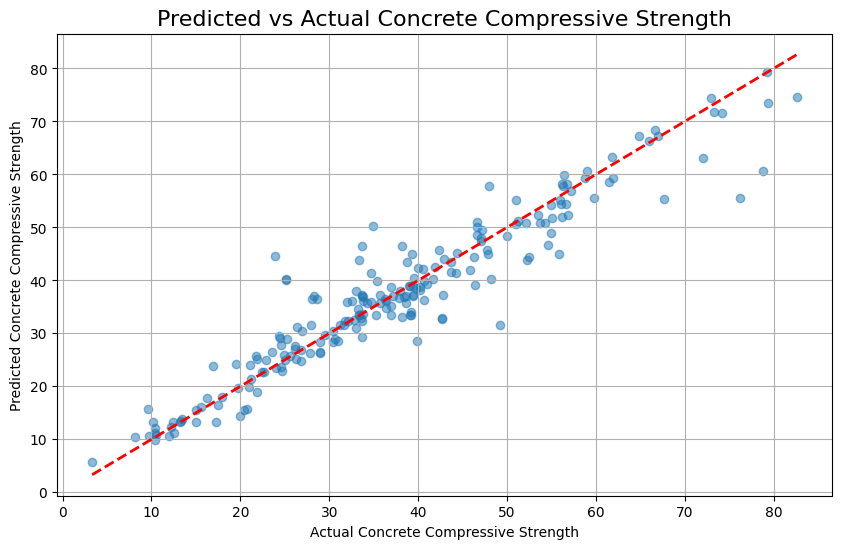

In [25]:
# Visualize the predicted vs actual concrete compressive strength
plt.figure(figsize=(10, 6))
plt.scatter(y_test, optimized_strength, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
plt.title("Predicted vs Actual Concrete Compressive Strength", fontsize=16)
plt.xlabel("Actual Concrete Compressive Strength")
plt.ylabel("Predicted Concrete Compressive Strength")
plt.grid()
plt.show()

In [26]:
# First check the actual column names in the DataFrame
print("Actual column names in X_train:")
print(X_train.columns.tolist())

Actual column names in X_train:
['Cement', 'Blast Furnace Slag', 'Fly Ash', 'Water', 'Superplasticizer', 'Coarse Aggregate', 'Fine Aggregate', 'Age']


In [27]:
# Objective function for Bayesian optimization
def objective_function(params):
    """
    Objective function to minimize the negative of the compressive strength.
    This function takes a the parameters of the concrete mix and returns the negative compressive strength.
    """
    # Unpack the parameters
    (
        cement,
        slag,
        ash,
        water,
        superplasticizer,
        coarse_aggregate,
        fine_aggregate,
        age,
    ) = params
    # Create a DataFrame with the parameters
    concrete_mix = pd.DataFrame(
        {
            "Cement": [cement],
            "Blast Furnace Slag": [slag],
            "Fly Ash": [ash],
            "Water": [water],
            "Superplasticizer": [superplasticizer],
            "Coarse Aggregate": [coarse_aggregate],
            "Fine Aggregate": [fine_aggregate],
            "Age": [age],
        }
    )
    # Predict the compressive strength using the optimized model
    predicted_strength = opt.predict(concrete_mix)
    # Return the negative compressive strength (as we want to maximize it)
    return -predicted_strength[0]

In [28]:
# Define the search space for the parameters of the concrete mix based on the min and max values in the training set
search_space_concrete = [
    (X_train["Cement"].min(), X_train["Cement"].max()),  # Cement
    (X_train["Blast Furnace Slag"].min(), X_train["Blast Furnace Slag"].max()),  # Slag
    (X_train["Fly Ash"].min(), X_train["Fly Ash"].max()),  # Ash
    (X_train["Water"].min(), X_train["Water"].max()),  # Water
    (
        X_train["Superplasticizer"].min(),
        X_train["Superplasticizer"].max(),
    ),  # Superplasticizer
    (
        X_train["Coarse Aggregate"].min(),
        X_train["Coarse Aggregate"].max(),
    ),  # Coarse Aggregate
    (
        X_train["Fine Aggregate"].min(),
        X_train["Fine Aggregate"].max(),
    ),  # Fine Aggregate
    (X_train["Age"].min(), X_train["Age"].max()),  # Age
]

In [29]:
from skopt import gp_minimize

# Perform Bayesian optimization to find the optimal concrete mix parameters
result = gp_minimize(
    objective_function,
    search_space_concrete,
    n_calls=50,  # Number of evaluations
    random_state=random_state,
    verbose=True,
)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0136
Function value obtained: -63.4746
Current minimum: -63.4746
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0112
Function value obtained: -66.6094
Current minimum: -66.6094
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0124
Function value obtained: -43.6483
Current minimum: -66.6094
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0121
Function value obtained: -61.9497
Current minimum: -66.6094
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.0105
Function value obtained: -62.9530
Current minimum: -66.6094
Iteration No: 6

Iteration No: 10 ended. Evaluation done at random point.
Time taken: 0.3997
Function value obtained: -54.2840
Current minimum: -66.6094
Iteration No: 11 started. Searching for the next optimal point.
Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 0.4116
Function value obtained: -68.0463
Current minimum: -68.0463
Iteration No: 12 started. Searching for the next optimal point.
Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 0.3918
Function value obtained: -64.8181
Current minimum: -68.0463
Iteration No: 13 started. Searching for the next optimal point.
Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 0.4788
Function value obtained: -67.5368
Current minimum: -68.0463
Iteration No: 14 started. Searching for the next optimal point.
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 0.5567
Function value obtained: -66.7682
Current minimum: -68.0463
Iteration No: 15 sta

In [30]:
# Neatly display the best parameters and the best predicted compressive strength along with column names
best_params = result.x
best_strength = -result.fun  # Negate the result to get the actual strength
print("Best parameters found by Bayesian optimization:")
for i, param in enumerate(best_params):
    print(f"{X_train.columns[i]}: {param}")
print(f"Best predicted Concrete Compressive Strength: {best_strength}")

Best parameters found by Bayesian optimization:
Cement: 487.70150373679013
Blast Furnace Slag: 347.1183478654907
Fly Ash: 0.0
Water: 182.7323305717219
Superplasticizer: 32.2
Coarse Aggregate: 907.2103294775172
Fine Aggregate: 738.2123914644791
Age: 364
Best predicted Concrete Compressive Strength: 71.20946078431382


## Use XGBoost for the Model instead of Random Forest

In [31]:
from xgboost import XGBRegressor

In [32]:
# Define the XGBoost model
xgb_model = XGBRegressor(random_state=random_state, n_jobs=-1)

In [33]:
# Define the Bayesian optimization search for XGBoost hyperparameters
xgb_search_space = {
    "n_estimators": (50, 500),  # Number of trees in the forest
    "max_depth": (3, 10),  # Maximum depth of the tree
    "learning_rate": (
        0.01,
        0.3,
        "uniform",
    ),  # Step size shrinkage used in update to prevent overfitting
    "subsample": (0.5, 1.0, "uniform"),  # Subsample ratio of the training instances
    "colsample_bytree": (
        0.5,
        1.0,
        "uniform",
    ),  # Subsample ratio of columns when constructing each tree
    "gamma": (
        0,
        5,
    ),  # Minimum loss reduction required to make a further partition on a leaf
    "reg_alpha": (0, 1),  # L1 regularization term on weights
    "reg_lambda": (0, 1),  # L2 regularization term on weights
}

In [34]:
# Define the Bayesian optimization search for XGBoost
xgb_opt = BayesSearchCV(
    xgb_model,
    xgb_search_space,
    n_iter=50,  # Number of iterations for optimization
    scoring="neg_mean_squared_error",  # Objective function to minimize
    cv=5,  # Cross-validation splitting strategy
    n_jobs=-1,  # Use all available cores
    random_state=random_state,
)

In [35]:
# Fit the XGBoost model using Bayesian optimization
xgb_opt.fit(X_train, y_train.values.ravel())

,estimator,"XGBRegressor(...ree=None, ...)"
,search_spaces,"{'colsample_bytree': (0.5, ...), 'gamma': (0, ...), 'learning_rate': (0.01, ...), 'max_depth': (3, ...), ...}"
,optimizer_kwargs,None
,n_iter,50
,scoring,'neg_mean_squared_error'
,fit_params,None
,n_jobs,-1
,n_points,1
,iid,'deprecated'
,refit,True
,cv,5


In [36]:
# Display the best parameters found by Bayesian optimization for XGBoost
print("Best parameters found by Bayesian optimization for XGBoost:")
pprint(xgb_opt.best_params_)

Best parameters found by Bayesian optimization for XGBoost:
OrderedDict([('colsample_bytree', 0.7387918853295966),
             ('gamma', 2),
             ('learning_rate', 0.2164450960574542),
             ('max_depth', 3),
             ('n_estimators', 412),
             ('reg_alpha', 0),
             ('reg_lambda', 1),
             ('subsample', 0.8929239047056037)])


In [37]:
# Display the best score achieved by XGBoost
print(f"Best score achieved (negative MSE) by XGBoost: {xgb_opt.best_score_}")

Best score achieved (negative MSE) by XGBoost: -18.560736082311223


In [38]:
# Evaluate the optimized XGBoost model on the test set
y_pred_xgb = xgb_opt.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
print(f"Mean Squared Error on test set by XGBoost: {mse_xgb}")

Mean Squared Error on test set by XGBoost: 23.31682777404785


In [39]:
# Use the optimized XGBoost model to predict concrete compressive strength
optimized_strength_xgb = xgb_opt.predict(X_test)
print("Predicted Concrete Compressive Strength using Optimized XGBoost Model:")
print(optimized_strength_xgb)

Predicted Concrete Compressive Strength using Optimized XGBoost Model:
[24.944765  16.143307  33.70291   16.768557  29.602345  72.656715
 17.141031  53.744003  40.31195   20.57573   34.113003  13.257078
 29.651583  33.898087  10.410432  27.832344  38.062454  57.744335
 58.24699   41.298462  20.18003   49.960114  18.306925  66.70059
 59.535057  45.41993   39.035496  33.96619   42.90428   13.346141
 42.21964   53.571857  28.02836   28.820803  32.911503  36.438053
 20.177486  25.022821  23.18557   17.916332  33.83424   14.20781
 47.54578   38.828865  36.204357  27.28811   34.26236   33.481346
 24.498596  49.502068  24.927536  36.73496   64.428     52.01119
 56.539913  11.418942  38.823967  23.61539   35.00708   43.332237
 51.212975  42.820274  50.182465  50.384583  20.055105  34.862812
 53.13528   35.883068  44.230873  27.48752   25.460405  27.087658
 38.114887  10.9710865 70.69242   63.508736  54.57394   14.66324
 57.551823  47.768707  43.937492  40.242386  56.594215  33.038136
 50.56392

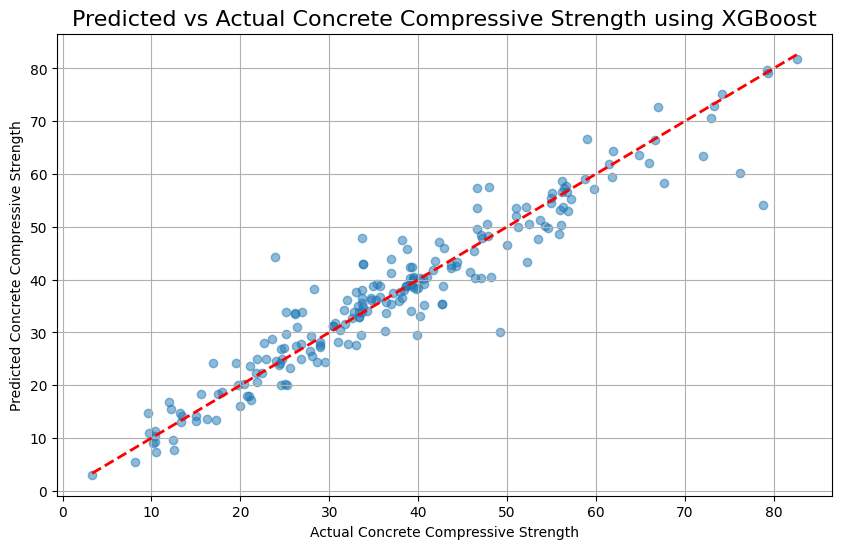

In [40]:
# Visualize the predicted vs actual concrete compressive strength using XGBoost
plt.figure(figsize=(10, 6))
plt.scatter(y_test, optimized_strength_xgb, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
plt.title(
    "Predicted vs Actual Concrete Compressive Strength using XGBoost", fontsize=16
)
plt.xlabel("Actual Concrete Compressive Strength")
plt.ylabel("Predicted Concrete Compressive Strength")
plt.grid()
plt.show()

In [41]:
# Objective function for Bayesian optimization with XGBoost
def objective_function_xgb(params):
    """
    Objective function to minimize the negative of the compressive strength using XGBoost.
    This function takes the parameters of the concrete mix and returns the negative compressive strength.
    """
    # Unpack the parameters
    (
        cement,
        slag,
        ash,
        water,
        superplasticizer,
        coarse_aggregate,
        fine_aggregate,
        age,
    ) = params
    # Create a DataFrame with the parameters
    concrete_mix = pd.DataFrame(
        {
            "Cement": [cement],
            "Blast Furnace Slag": [slag],
            "Fly Ash": [ash],
            "Water": [water],
            "Superplasticizer": [superplasticizer],
            "Coarse Aggregate": [coarse_aggregate],
            "Fine Aggregate": [fine_aggregate],
            "Age": [age],
        }
    )
    # Predict the compressive strength using the optimized XGBoost model
    predicted_strength = xgb_opt.predict(concrete_mix)
    # Return the negative compressive strength (as we want to maximize it)
    return -predicted_strength[0]

In [42]:
# Define the search space for the parameters of the concrete mix based on the min and max values in the training set
search_space_concrete_xgb = [
    (X_train["Cement"].min(), X_train["Cement"].max()),  # Cement
    (X_train["Blast Furnace Slag"].min(), X_train["Blast Furnace Slag"].max()),  # Slag
    (X_train["Fly Ash"].min(), X_train["Fly Ash"].max()),  # Ash
    (X_train["Water"].min(), X_train["Water"].max()),  # Water
    (
        X_train["Superplasticizer"].min(),
        X_train["Superplasticizer"].max(),
    ),  # Superplasticizer
    (
        X_train["Coarse Aggregate"].min(),
        X_train["Coarse Aggregate"].max(),
    ),  # Coarse Aggregate
    (
        X_train["Fine Aggregate"].min(),
        X_train["Fine Aggregate"].max(),
    ),  # Fine Aggregate
    (X_train["Age"].min(), X_train["Age"].max()),  # Age
]

In [43]:
from skopt import gp_minimize

# Perform Bayesian optimization to find the optimal concrete mix parameters using XGBoost
result_xgb = gp_minimize(
    objective_function_xgb,
    search_space_concrete_xgb,
    n_calls=50,  # Number of evaluations
    random_state=random_state,
    verbose=True,
)

Iteration No: 1 started. Evaluating function at random point.


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0074
Function value obtained: -79.0238
Current minimum: -79.0238
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0024
Function value obtained: -83.5940
Current minimum: -83.5940
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0024
Function value obtained: -56.1751
Current minimum: -83.5940
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0023
Function value obtained: -80.1988
Current minimum: -83.5940
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.0023
Function value obtained: -52.6574
Current minimum: -83.5940
Iteration No: 6 started. Evaluating function at random point.
Iteration No: 6

In [44]:
# Neatly display the best parameters and the best predicted compressive strength along with column names for XGBoost
best_params_xgb = result_xgb.x
best_strength_xgb = -result_xgb.fun  # Negate the result to get the actual strength
print("Best parameters found by Bayesian optimization for XGBoost:")
for i, param in enumerate(best_params_xgb):
    print(f"{X_train.columns[i]}: {param}")
print(
    f"Best predicted Concrete Compressive Strength using XGBoost: {best_strength_xgb}"
)

Best parameters found by Bayesian optimization for XGBoost:
Cement: 540.0
Blast Furnace Slag: 359.4
Fly Ash: 98.67465219587248
Water: 193.96461471359797
Superplasticizer: 32.2
Coarse Aggregate: 1012.4226737904359
Fine Aggregate: 637.822662638726
Age: 365
Best predicted Concrete Compressive Strength using XGBoost: 95.66382598876953


# Human-in-the-Loop Preference Learning for Bayesian Optimization
A Human-in-the-Loop (HITL) approach to guide the Bayesian optimization process using preference learning is implemented. For simulation purposes, a human expert is simulated to provide subjective feedback on wine profiles, which will be used to train a user belief model. This model will then be combined with the main surrogate model to create a more informed acquisition function.

## Simulate the Human Expert
This will compare two concrete mix profiles and indicate a preference based on their proximity to a "golden standard" profile, which is defined using the best parameters found by the XGBoost optimization.

In [45]:
import numpy as np

# Golden standard profile based on XGBoost optimization results
golden_standard_profile = result_xgb.x


def simulate_human_expert(profile1, profile2):
    """
    Simulates a human expert's preference between two concrete mix profiles.
    The preference is based on the Euclidean distance to a golden standard profile.

    Args:
        profile1 (list): The first concrete mix profile.
        profile2 (list): The second concrete mix profile.

    Returns:
        int: 1 if profile1 is preferred, 0 otherwise.
    """
    dist1 = np.linalg.norm(np.array(profile1) - golden_standard_profile)
    dist2 = np.linalg.norm(np.array(profile2) - golden_standard_profile)
    if dist1 < dist2:
        return 1  # Prefers profile1
    else:
        return 0  # Prefers profile2


# Example usage:
# Create two random profiles for demonstration
random_profile1 = [X_train.iloc[0, i] for i in range(X_train.shape[1])]
random_profile2 = [X_train.iloc[1, i] for i in range(X_train.shape[1])]
preference = simulate_human_expert(random_profile1, random_profile2)
print(f"Simulated expert preference: {preference}")

Simulated expert preference: 0


## Implement the Preference Learning Component
This involves generating pairs of candidate concrete mix profiles, eliciting preferences from our simulated expert, and training a user belief model—a Gaussian Process Classifier (GPC)—on this preference data. The GPC will learn to predict the expert's preferences, which will help guide the optimization.

In [46]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
import warnings

# Suppress warnings from GPC
warnings.filterwarnings("ignore", category=UserWarning)


# Initialize the user belief model (GPC)
# A radial-basis function (RBF) kernel is a common choice
kernel = 1.0 * RBF(length_scale=1.0)
user_belief_model = GaussianProcessClassifier(kernel=kernel, random_state=random_state)

# Generate initial preference data to train the GPC
n_initial_pairs = 10
preference_data = []
preference_labels = []

for _ in range(n_initial_pairs):
    # Generate two random profiles from the search space
    x1 = [np.random.uniform(low, high) for low, high in search_space_concrete_xgb]
    x2 = [np.random.uniform(low, high) for low, high in search_space_concrete_xgb]

    # Get the simulated expert's preference
    preference = simulate_human_expert(x1, x2)

    # Store the preference data
    # We create a feature vector that is the difference between the two profiles
    preference_data.append(np.array(x1) - np.array(x2))
    preference_labels.append(preference)

# Train the initial user belief model
user_belief_model.fit(preference_data, preference_labels)

print("Initial user belief model trained.")

Initial user belief model trained.


## Modify the Bayesian Optimization Loop
A new acquisition function is created that combines the predictions from our main surrogate model (XGBoost) and the user belief model (GPC). This new function will guide the selection of candidate profiles by balancing predicted compressive strength with the simulated expert's preferences. A custom optimization loop is implemented to accommodate this HITL approach.

In [47]:
from scipy.optimize import minimize
import time

# --- Configuration ---
n_iterations = 50
n_candidates_per_iteration = (
    100  # Number of random candidates to evaluate with the acquisition function
)
acquisition_weight = 0.5  # Weight for combining surrogate and belief models

# --- Initialization ---
# Use the best XGBoost model as the main surrogate
main_surrogate_model = xgb_opt.best_estimator_

# Store the history of evaluated points and their objective values
evaluated_points = []
objective_values = []

# Store the convergence history
convergence_hitl = []
best_strength_so_far = -np.inf

# --- Custom Optimization Loop ---
start_time = time.time()

for i in range(n_iterations):
    print(f"--- Iteration {i+1}/{n_iterations} ---")

    # 1. Generate candidate profiles to evaluate with the acquisition function
    candidates = []
    for _ in range(n_candidates_per_iteration):
        candidate = [
            np.random.uniform(low, high) for low, high in search_space_concrete_xgb
        ]
        candidates.append(candidate)

    # 2. Define and evaluate the new acquisition function for each candidate
    def acquisition_function(x):
        x_df = pd.DataFrame([x], columns=X_train.columns)

        # a) Prediction from the main surrogate model (XGBoost)
        pred_strength = main_surrogate_model.predict(x_df)[0]

        # b) Prediction from the user belief model (GPC)
        pred_preference = user_belief_model.predict_proba(np.array(x).reshape(1, -1))[
            0
        ][1]

        # c) Combine the two predictions (weighted average)
        return (
            acquisition_weight * pred_strength
            + (1 - acquisition_weight) * pred_preference
        )

    # Evaluate acquisition function for all candidates
    acquisition_scores = [acquisition_function(c) for c in candidates]

    # 3. Select the best candidate
    best_candidate_index = np.argmax(acquisition_scores)
    next_point = candidates[best_candidate_index]
    print(f"Selected new point to evaluate.")

    # 4. Evaluate the selected point with the true objective function
    true_objective_value = -objective_function_xgb(next_point)  # Negate to get strength
    print(f"True strength of new point: {true_objective_value:.4f}")

    # Store the results
    evaluated_points.append(next_point)
    objective_values.append(true_objective_value)

    # Update convergence tracking
    if true_objective_value > best_strength_so_far:
        best_strength_so_far = true_objective_value
    convergence_hitl.append(best_strength_so_far)

    # 5. Update the user belief model with new preference data
    if len(evaluated_points) > 1:
        random_index = np.random.randint(0, len(evaluated_points) - 1)
        profile1 = next_point
        profile2 = evaluated_points[random_index]

        preference = simulate_human_expert(profile1, profile2)

        if preference == 1:
            new_data_point = np.array(profile1) - np.array(profile2)
            new_label = 1
        else:
            new_data_point = np.array(profile2) - np.array(profile1)
            new_label = 1

        preference_data.append(new_data_point)
        preference_labels.append(new_label)
        user_belief_model.fit(preference_data, preference_labels)
        print("User belief model updated.")

end_time = time.time()
print(f"\nHITL optimization finished in {end_time - start_time:.2f} seconds.")

# --- Final Results ---
best_hitl_index = np.argmax(objective_values)
best_params_hitl = evaluated_points[best_hitl_index]
best_strength_hitl = objective_values[best_hitl_index]

print("\nBest parameters found by HITL Bayesian optimization:")
for i, param in enumerate(best_params_hitl):
    print(f"{X_train.columns[i]}: {param}")
print(f"\nBest predicted compressive strength using HITL: {best_strength_hitl}")

--- Iteration 1/50 ---
Selected new point to evaluate.
True strength of new point: 91.9723
--- Iteration 2/50 ---
Selected new point to evaluate.
True strength of new point: 101.5198
User belief model updated.
--- Iteration 3/50 ---
Selected new point to evaluate.
True strength of new point: 89.2786
User belief model updated.
--- Iteration 4/50 ---
Selected new point to evaluate.
True strength of new point: 84.8610
User belief model updated.
--- Iteration 5/50 ---
Selected new point to evaluate.
True strength of new point: 87.0449
User belief model updated.
--- Iteration 6/50 ---
Selected new point to evaluate.
True strength of new point: 87.1370
User belief model updated.
--- Iteration 7/50 ---
Selected new point to evaluate.
True strength of new point: 88.4738
User belief model updated.
--- Iteration 8/50 ---
Selected new point to evaluate.
True strength of new point: 90.0366
User belief model updated.
--- Iteration 9/50 ---
Selected new point to evaluate.
True strength of new point:

## Final Evaluation


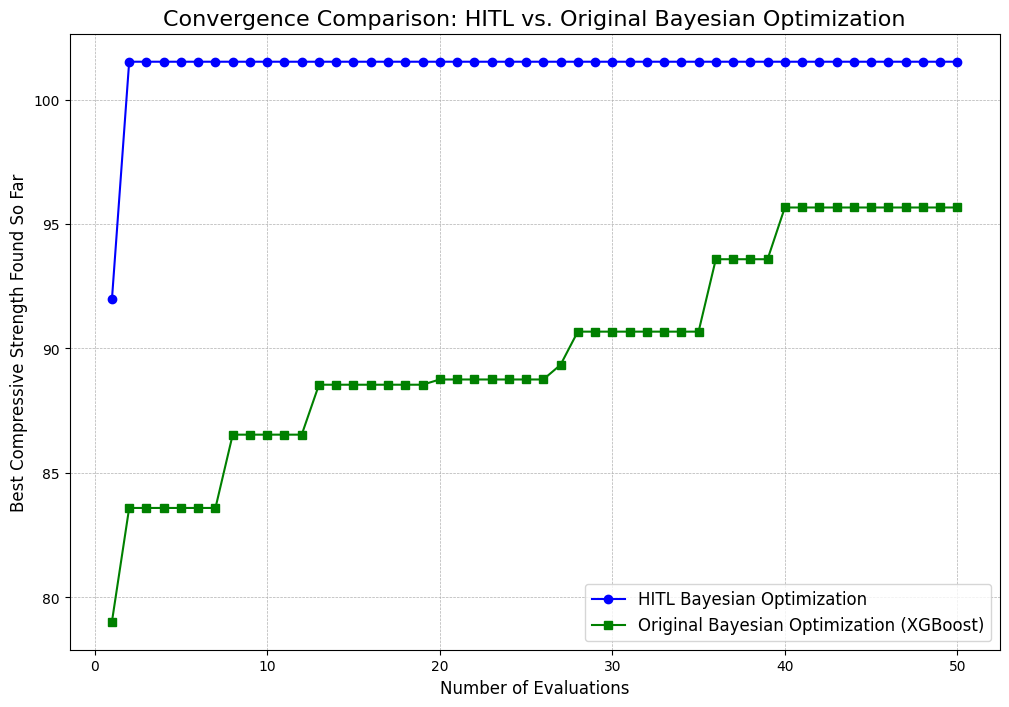

--- Comparison of Best Results ---

Original Bayesian Optimization (XGBoost):
  Best Compressive Strength: 95.6638
  Best Profile:
    Cement: 540.0000
    Blast Furnace Slag: 359.4000
    Fly Ash: 98.6747
    Water: 193.9646
    Superplasticizer: 32.2000
    Coarse Aggregate: 1012.4227
    Fine Aggregate: 637.8227
    Age: 365.0000

HITL Bayesian Optimization:
  Best Compressive Strength: 101.5198
  Best Profile:
    Cement: 505.0154
    Blast Furnace Slag: 241.3962
    Fly Ash: 51.9236
    Water: 160.7782
    Superplasticizer: 12.0060
    Coarse Aggregate: 856.7337
    Fine Aggregate: 659.5514
    Age: 200.0999


In [48]:
# --- Prepare Data for Comparison ---
# Get the convergence data from the original gp_minimize result
convergence_original = np.maximum.accumulate(-np.array(result_xgb.func_vals))

# Ensure both convergence plots are of the same length
num_evaluations = min(len(convergence_hitl), len(convergence_original))
convergence_hitl_plot = convergence_hitl[:num_evaluations]
convergence_original_plot = convergence_original[:num_evaluations]

# --- Plotting the Convergence ---
plt.figure(figsize=(12, 8))
plt.plot(
    range(1, num_evaluations + 1),
    convergence_hitl_plot,
    "o-",
    label="HITL Bayesian Optimization",
    color="blue",
)
plt.plot(
    range(1, num_evaluations + 1),
    convergence_original_plot,
    "s-",
    label="Original Bayesian Optimization (XGBoost)",
    color="green",
)
plt.title(
    "Convergence Comparison: HITL vs. Original Bayesian Optimization", fontsize=16
)
plt.xlabel("Number of Evaluations", fontsize=12)
plt.ylabel("Best Compressive Strength Found So Far", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

# --- Comparing the Best Results ---
print("--- Comparison of Best Results ---")
print("\nOriginal Bayesian Optimization (XGBoost):")
print(f"  Best Compressive Strength: {best_strength_xgb:.4f}")
print("  Best Profile:")
for i, param in enumerate(best_params_xgb):
    print(f"    {X_train.columns[i]}: {param:.4f}")

print("\nHITL Bayesian Optimization:")
print(f"  Best Compressive Strength: {best_strength_hitl:.4f}")
print("  Best Profile:")
for i, param in enumerate(best_params_hitl):
    print(f"    {X_train.columns[i]}: {param:.4f}")